## EKLAVYA SHARMA
### 8902545

Obtain dataset

In [1]:
import os
from tensorflow.keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import to_categorical
from sklearn.metrics import precision_recall_curve, auc
import shutil



In [4]:
source_train = r"C:\Users\ekyus\Downloads\Birds\train"
source_test = r"C:\Users\ekyus\Downloads\Birds\test"
source_validation = r"C:\Users\ekyus\Downloads\Birds\valid"

# Initiate an empty dictionary to count image numbers for each sub-directory in the dataset
image_tally = {}

# Traverse through directories and files, replacing the count_images and find_top3_classes functions
for sub_directory in os.scandir(source_train):
    if sub_directory.is_dir():
        total_images = 0
        for file in os.scandir(sub_directory.path):
            if file.is_file():
                total_images += 1
        image_tally[sub_directory] = total_images

# Sorting the dictionary in descending order
image_tally_sorted = sorted(image_tally.items(), key=lambda pair: pair[1], reverse=True)

# Output the top classes
image_tally_sorted[:10]
## we will use only top 3

[(<DirEntry 'RUFOUS TREPE'>, 263),
 (<DirEntry 'HOUSE FINCH'>, 248),
 (<DirEntry 'D-ARNAUDS BARBET'>, 233),
 (<DirEntry 'OVENBIRD'>, 233),
 (<DirEntry 'ASIAN GREEN BEE EATER'>, 220),
 (<DirEntry 'SWINHOES PHEASANT'>, 216),
 (<DirEntry 'WOOD DUCK'>, 214),
 (<DirEntry 'CASPIAN TERN'>, 213),
 (<DirEntry 'RED BILLED TROPICBIRD'>, 212),
 (<DirEntry 'WOOD THRUSH'>, 211)]

In [5]:
prime_categories = ['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET']

def purge_unwanted_folders(path):
    for item in os.scandir(path):
        if item.is_file():
            os.remove(item.path)
        elif item.is_dir() and item.name not in prime_categories:
            # Recursive deletion for nested content
            purge_unwanted_folders(item.path)
            # Delete the now-empty directory
            os.rmdir(item.path)

# Invoke the function for dataset subsets
for path in [source_train, source_test, source_validation]:
    purge_unwanted_folders(path)

Use data-augmentation to increase the number of training images. You are encouraged to try out various augmentation methods supported by Keras. The rule of thumb is that as long as an augmentation produces realistic images - it is probably a good idea to add it.(2 point)

In [6]:
training_dataset = image_dataset_from_directory(source_train, image_size=(224,224), batch_size=32)
validation_dataset = image_dataset_from_directory(source_validation, image_size=(224,224), batch_size=32)
testing_dataset = image_dataset_from_directory(source_test, image_size=(224,224), batch_size=32)

Found 744 files belonging to 3 classes.
Found 15 files belonging to 3 classes.
Found 15 files belonging to 3 classes.


In [7]:
augmented_dataset = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

training_data_generator = augmented_dataset.flow_from_directory(
    source_train,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

Found 744 images belonging to 3 classes.


In [8]:
validation_dataset_rescaled = ImageDataGenerator(rescale=1.0/255)

validation_data_generator = augmented_dataset.flow_from_directory(
    source_validation,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

Found 15 images belonging to 3 classes.


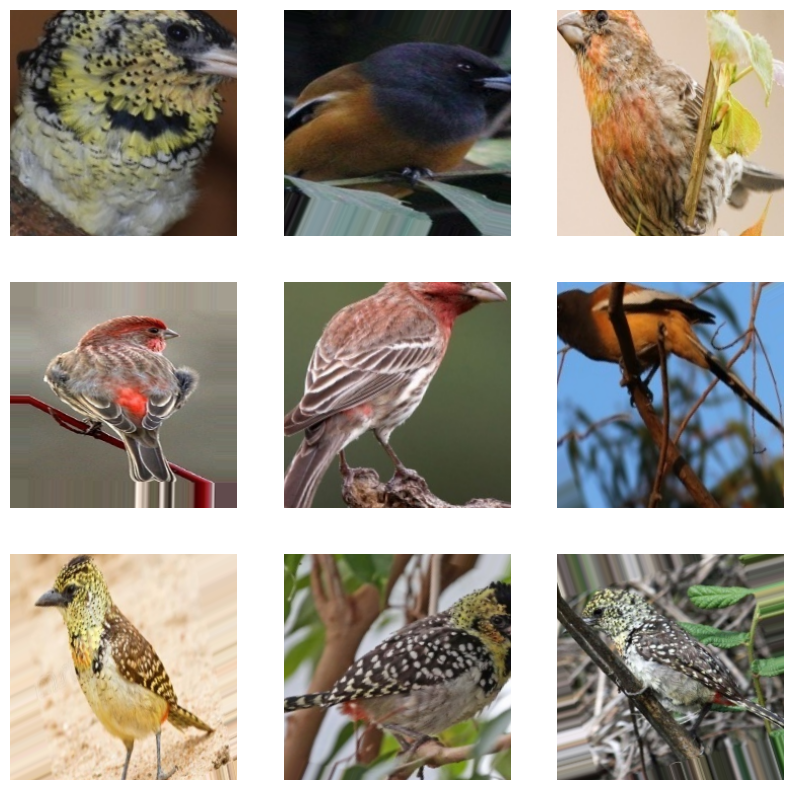

In [9]:
img, _ = next(training_data_generator)

plt.figure(figsize=(10,10))

for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(img[i].astype('uint8'))
    plt.axis('off')
plt.show()

Fine-Tune VGG16 (pre-trained on imagenet), to classify the 3 classes (2 points)

In [10]:
foundational_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
foundational_model.summary()

58889256/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [12]:
from tensorflow.keras import layers

# Make all layers in the foundational_model non-trainable
for layer in foundational_model.layers:
    layer.trainable = False

input_layer = tf.keras.Input(shape=(224, 224, 3))

transitional_layer = foundational_model(input_layer)
transitional_layer = layers.GlobalAveragePooling2D()(transitional_layer)
transitional_layer = layers.Dense(512, activation='relu')(transitional_layer)
transitional_layer = layers.Dropout(0.5)(transitional_layer)

output_layer = layers.Dense(3, activation='softmax')(transitional_layer)
neural_network_model = tf.keras.Model(input_layer, output_layer)

neural_network_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                             

In [13]:
neural_network_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
training_record = neural_network_model.fit(training_data_generator, epochs=10, validation_data=validation_data_generator)


Epoch 1/10
24/24 [==============================] - 46s 2s/step - loss: 2.0991 - accuracy: 0.7970 - val_loss: 0.2466 - val_accuracy: 0.9333
Epoch 2/10
24/24 [==============================] - 44s 2s/step - loss: 0.5526 - accuracy: 0.9315 - val_loss: 0.7272 - val_accuracy: 0.9333
Epoch 3/10
24/24 [==============================] - 45s 2s/step - loss: 0.3403 - accuracy: 0.9435 - val_loss: 5.1333e-05 - val_accuracy: 1.0000
Epoch 4/10
24/24 [==============================] - 46s 2s/step - loss: 0.1405 - accuracy: 0.9597 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 47s 2s/step - loss: 0.1372 - accuracy: 0.9731 - val_loss: 1.8283e-04 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 48s 2s/step - loss: 0.1565 - accuracy: 0.9718 - val_loss: 5.4268e-04 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 47s 2s/step - loss: 0.1380 - accuracy: 0.9637 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 8/

Explore the model performance: accuracy, confusion metric, precision, recall, F1-score, precision-recall curve and its area under the curve (AUC). Explore specific examples in which the model failed to predict correctly.

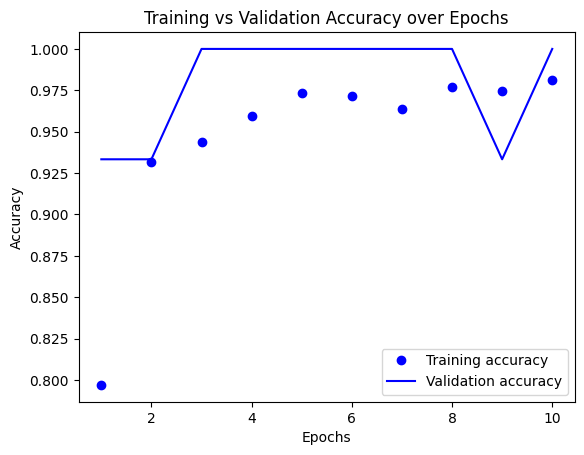

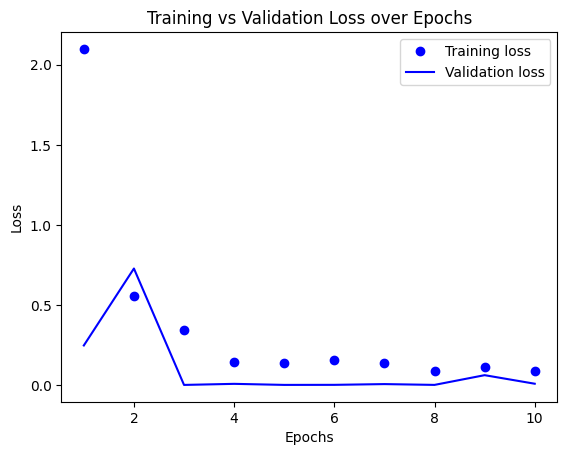

In [15]:
# Extract accuracy and loss history for training and validation
train_accuracy = training_record.history["accuracy"]
valid_accuracy = training_record.history["val_accuracy"]
train_loss = training_record.history["loss"]
valid_loss = training_record.history["val_loss"]
epoch_count = range(1, len(train_accuracy) + 1)

# Plot the training and validation accuracy per epoch
plt.plot(epoch_count, train_accuracy, "bo", label="Training accuracy")
plt.plot(epoch_count, valid_accuracy, "b", label="Validation accuracy")
plt.title("Training vs Validation Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot the training and validation loss per epoch
plt.plot(epoch_count, train_loss, "bo", label="Training loss")
plt.plot(epoch_count, valid_loss, "b", label="Validation loss")
plt.title("Training vs Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [16]:
evaluation_loss, evaluation_accuracy = neural_network_model.evaluate(validation_data_generator)
print(evaluation_accuracy)


1/1 [==============================] - 1s 984ms/step - loss: 1.5694e-05 - accuracy: 1.0000
1.0


In [17]:
predictions = neural_network_model.predict(validation_data_generator)
predictions_classes = np.argmax(predictions, axis=1)

actual_classes = validation_data_generator.classes

# Generate confusion matrix
confusion_mtx = confusion_matrix(actual_classes, predictions_classes)

# Print precision, recall, and F1-score
print(classification_report(actual_classes, predictions_classes, target_names=validation_data_generator.class_indices.keys()))


1/1 [==============================] - 1s 1s/step
                  precision    recall  f1-score   support

D-ARNAUDS BARBET       0.40      0.40      0.40         5
     HOUSE FINCH       0.40      0.40      0.40         5
    RUFOUS TREPE       0.60      0.60      0.60         5

        accuracy                           0.47        15
       macro avg       0.47      0.47      0.47        15
    weighted avg       0.47      0.47      0.47        15



AUC for D-ARNAUDS BARBET: 0.2508558108558109
AUC for HOUSE FINCH: 0.38844322344322346
AUC for RUFOUS TREPE: 0.6513888888888888


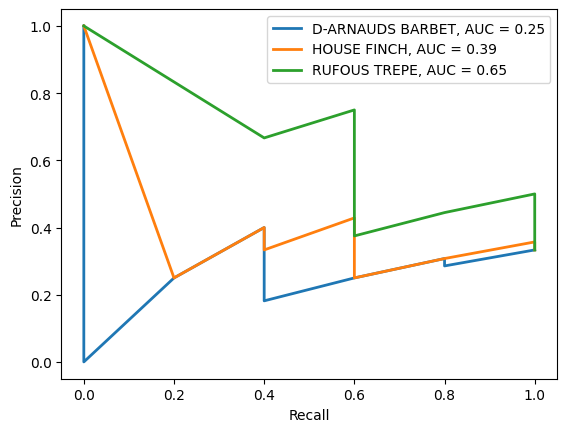

In [18]:

y_true_one_hot = to_categorical(actual_classes)
class_names = {v: k for k, v in validation_data_generator.class_indices.items()}

for i in range(3):
    precision, recall, _ = precision_recall_curve(y_true_one_hot[:, i], predictions[:, i])
    auc_score = auc(recall, precision)
    class_name = class_names[i]
    print(f'AUC for {class_name}: {auc_score}')
    plt.plot(recall, precision, lw=2, label='{}, AUC = {:.2f}'.format(class_name, auc_score))

# plot

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

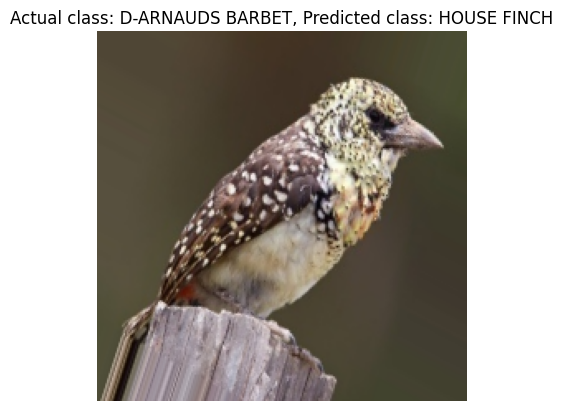

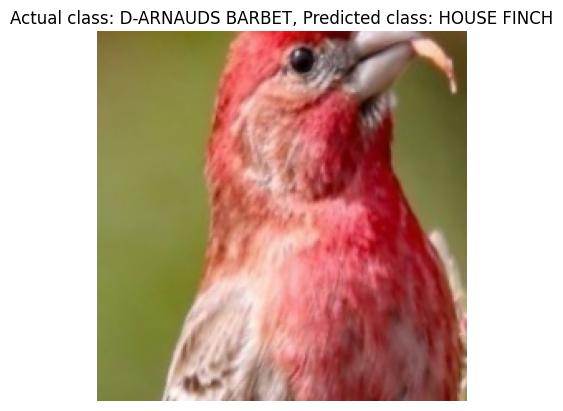

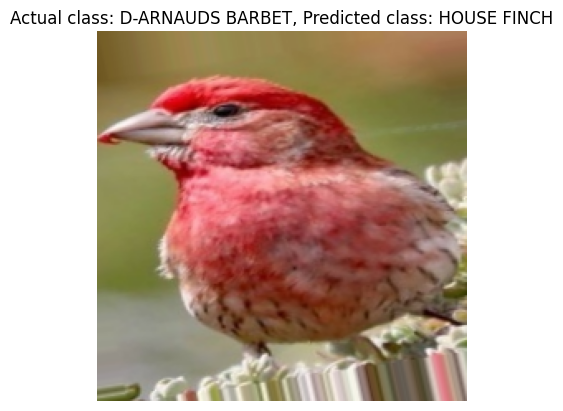

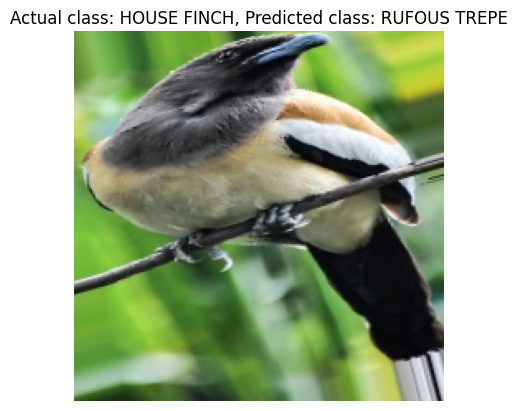

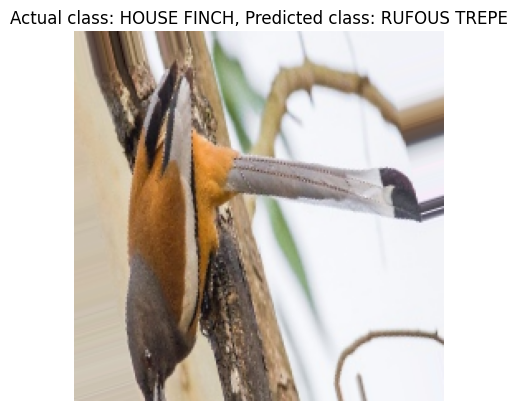

In [20]:
incorrect_indices = np.where(predictions_classes != actual_classes)[0]

# Visualize 5 incorrectly classified examples
for idx in incorrect_indices[:5]:
    img_group, _ = validation_data_generator[idx // validation_data_generator.batch_size]
    img_sample = img_group[idx % validation_data_generator.batch_size]
    
    actual_class_label = class_label_dict[actual_classes[idx]]
    predicted_class_label = class_label_dict[predictions_classes[idx]]

    plt.imshow(img_sample.astype('uint8'))
    plt.title(f'Actual class: {actual_class_label}, Predicted class: {predicted_class_label}')
    plt.axis('off')
    plt.show()
